# 🖥️ Sesi 3 - Notebook 2
# Plotly Interactive Visualizations

Bagian ini mengikuti segmen Plotly dari `slides/03_session3_visualization.md` agar interaktivitas yang ditunjukkan di kelas langsung bisa dicoba.

## 🎯 Tujuan Pembelajaran
- Membuat chart interaktif cepat dengan Plotly Express
- Menggunakan Plotly Graph Objects untuk kontrol penuh
- Menggabungkan beberapa chart dalam dashboard interaktif
- Menambahkan hover detail, annotation, dan range slider
- Mengekspor chart ke HTML atau gambar statis

## 📦 Library Setup
```bash
pip install plotly pandas numpy
# Untuk export gambar statis (opsional)
pip install kaleido
```

In [1]:

import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

warnings.filterwarnings('ignore')
print(f"Plotly version: {plotly.__version__}")

Plotly version: 6.4.0


## 📁 Load Dataset

In [2]:

DATASET_FILENAME = 'RUP-PaketPenyedia-Terumumkan-2025.parquet'
candidate_paths = [
    Path('../../../datasets/rup') / DATASET_FILENAME,
    Path('../../datasets/rup') / DATASET_FILENAME,
    Path('../datasets/rup') / DATASET_FILENAME,
    Path('datasets/rup') / DATASET_FILENAME,
]
for path in candidate_paths:
    if path.exists():
        DATA_PATH = path.resolve()
        break
else:
    raise FileNotFoundError('Dataset RUP 2025 tidak ditemukan.')

print(f"Dataset path: {DATA_PATH}")
df = pd.read_parquet(DATA_PATH)
df['tgl_pengumuman_paket'] = pd.to_datetime(df['tgl_pengumuman_paket'], errors='coerce')
print(df.shape)
df.head()
metode_counts = df['metode_pengadaan'].value_counts()


Dataset path: /home/rizko/coding/python/project/data-science/datasets/rup/RUP-PaketPenyedia-Terumumkan-2025.parquet
(16430, 48)


## 1. Plotly Express (Quick Plots)
### 1.1 Interactive Bar Chart - Top Satker

In [3]:

top_satker = (
    df.groupby('nama_satker')['pagu']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
top_satker.columns = ['Satker', 'Total Pagu']
fig = px.bar(top_satker, x='Satker', y='Total Pagu', title='Top 10 Satker by Total Pagu',
             labels={'Total Pagu': 'Total Pagu (Rupiah)'}, color='Total Pagu', color_continuous_scale='Blues')
fig.update_layout(xaxis_tickangle=-45, height=500, hovermode='x unified')
fig.show()

### 1.2 Histogram Interaktif

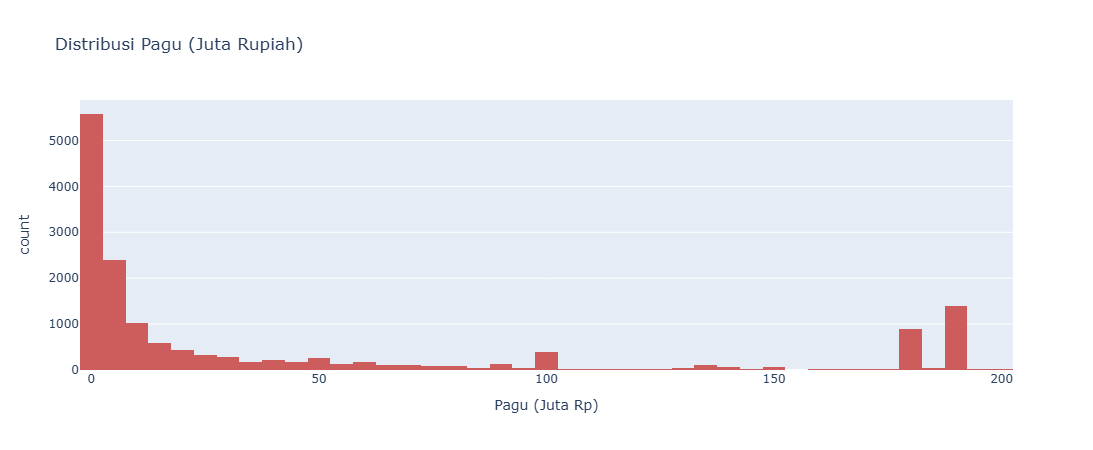

In [4]:

filtered = df[df['pagu'] < df['pagu'].quantile(0.95)].copy()
filtered['pagu_juta'] = filtered['pagu'] / 1_000_000
fig = px.histogram(filtered, x='pagu_juta', nbins=50, title='Distribusi Pagu (Juta Rupiah)',
                   labels={'pagu_juta': 'Pagu (Juta Rp)'}, color_discrete_sequence=['indianred'])
fig.update_layout(height=450, hovermode='x unified')
fig.show()

### 1.3 Scatter / Bubble Plot

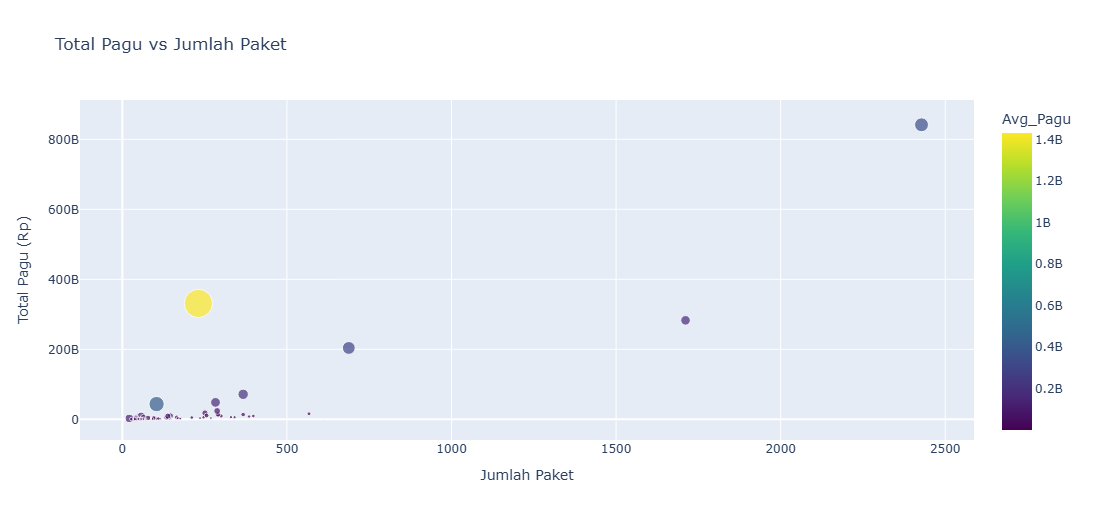

In [5]:

satker_stats = df.groupby('nama_satker')['pagu'].agg(['sum', 'mean', 'count']).reset_index()
satker_stats.columns = ['Satker', 'Total_Pagu', 'Avg_Pagu', 'Jumlah_Paket']
satker_stats = satker_stats[satker_stats['Jumlah_Paket'] > 5]
fig = px.scatter(satker_stats, x='Jumlah_Paket', y='Total_Pagu', size='Avg_Pagu', color='Avg_Pagu',
                 hover_name='Satker', title='Total Pagu vs Jumlah Paket',
                 labels={'Jumlah_Paket': 'Jumlah Paket', 'Total_Pagu': 'Total Pagu (Rp)'},
                 color_continuous_scale='Viridis', opacity=0.7)
fig.update_layout(height=520)
fig.show()

### 1.4 Line Chart + Moving Average

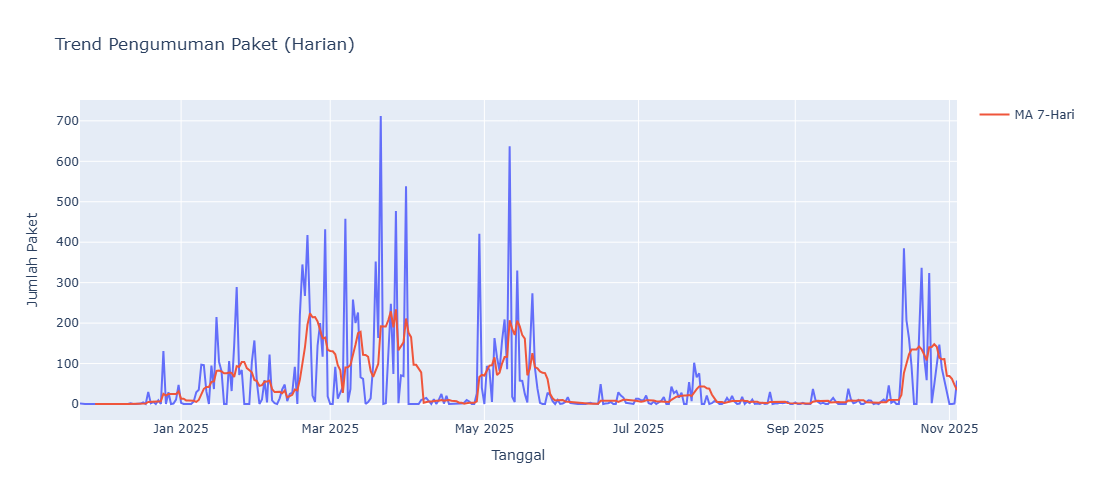

In [6]:

daily_counts = df.set_index('tgl_pengumuman_paket').resample('D').size().reset_index(name='jumlah_paket')
daily_counts['ma_7'] = daily_counts['jumlah_paket'].rolling(7).mean()
fig = px.line(daily_counts, x='tgl_pengumuman_paket', y='jumlah_paket', title='Trend Pengumuman Paket (Harian)')
fig.add_scatter(x=daily_counts['tgl_pengumuman_paket'], y=daily_counts['ma_7'], mode='lines', name='MA 7-Hari')
fig.update_layout(xaxis_title='Tanggal', yaxis_title='Jumlah Paket', height=500)
fig.show()

### 1.5 Sunburst (Metode ➜ Jenis)

In [7]:

subset = df.copy()
subset['Metode'] = subset['metode_pengadaan'].fillna('Lainnya')
subset['Jenis'] = subset['jenis_pengadaan'].fillna('Lainnya')
fig = px.sunburst(subset, path=['Metode', 'Jenis'], values='pagu',
                 title='Sunburst: Metode ➜ Jenis', color='Metode')
fig.update_layout(height=600)
fig.show()

## 2. Plotly Graph Objects (Full Control)
### 2.1 Multi-Line Trend per Metode

In [8]:

fig = go.Figure()
for metode, group in df.dropna(subset=['tgl_pengumuman_paket']).groupby('metode_pengadaan'):
    monthly = group.set_index('tgl_pengumuman_paket').resample('M').size()
    fig.add_trace(go.Scatter(x=monthly.index, y=monthly.values, mode='lines+markers', name=metode))
fig.update_layout(title='Trend Bulanan per Metode Pengadaan', xaxis_title='Bulan', yaxis_title='Jumlah Paket',
                  hovermode='x unified', height=550)
fig.show()

### 2.2 Dashboard Subplots

In [9]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Top 5 Satker', 'Metode Share', 'Distribusi Pagu', 'Running Total'),
    specs=[[{'type': 'bar'}, {'type': 'domain'}],
           [{'type': 'histogram'}, {'type': 'xy'}]]
)

# Bar
fig.add_trace(go.Bar(x=top_satker['Satker'][:5], y=top_satker['Total Pagu'][:5], name='Top Satker'), row=1, col=1)

# Pie
fig.add_trace(go.Pie(labels=metode_counts.index[:5], values=metode_counts.values[:5], name='Metode'), row=1, col=2)

# Histogram
pagu_hist = filtered['pagu_juta']
fig.add_trace(go.Histogram(x=pagu_hist, nbinsx=40, name='Pagu (Juta)'), row=2, col=1)

# Running total
daily_counts['running'] = daily_counts['jumlah_paket'].cumsum()
fig.add_trace(go.Scatter(x=daily_counts['tgl_pengumuman_paket'], y=daily_counts['running'], mode='lines',
                         name='Running Total'), row=2, col=2)

fig.update_layout(height=820, title='Interactive Dashboard', showlegend=False)
fig.show()

ValueError: Trace type 'pie' is not compatible with subplot type 'xy'
at grid position (1, 2)

See the docstring for the specs argument to plotly.subplots.make_subplots
for more information on subplot types

### 2.3 Custom Hover & Annotation

In [ ]:

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=top_satker['Satker'],
    y=top_satker['Total Pagu'],
    mode='lines+markers',
    line=dict(color='purple', width=3),
    marker=dict(size=10),
    hovertemplate='<b>%{x}</b><br>Total Pagu: Rp %{y:,.0f}<extra></extra>'
))
max_idx = top_satker['Total Pagu'].idxmax()
fig.add_annotation(x=top_satker.loc[max_idx, 'Satker'], y=top_satker.loc[max_idx, 'Total Pagu'],
                   text='Satker Tertinggi', showarrow=True, arrowhead=2)
fig.update_layout(title='Custom Hover & Annotation', xaxis_tickangle=-45, height=450)
fig.show()

## 3. Export Chart

In [ ]:

export_dir = Path('../outputs')
export_dir.mkdir(parents=True, exist_ok=True)
html_path = export_dir / 'plotly_dashboard.html'
fig.write_html(html_path)
print(f'✅ Interactive HTML saved to {html_path}')

try:
    png_path = export_dir / 'plotly_dashboard.png'
    fig.write_image(png_path, width=1200, height=700)
    print(f'✅ PNG saved to {png_path}')
except Exception as exc:
    print('ℹ️ PNG export skipped (install kaleido to enable).')
    print(exc)

## 4. Tips & Templates
- Gunakan `fig.update_layout(template='plotly_dark')` untuk tema cepat.
- Hovermode `'x unified'` memudahkan perbandingan antar garis.
- `fig.update_traces(selector=...)` berguna untuk styling trace tertentu.
- Aktifkan range slider dengan `fig.update_xaxes(rangeslider_visible=True)` pada time series.
- Simpan chart penting sebagai HTML agar bisa dibuka ulang di browser/Notion.

## 5. Latihan Mandiri
1. Buat stacked bar chart (Plotly Express) untuk membandingkan jenis pengadaan per metode.
2. Tambahkan dropdown (Graph Objects) agar user bisa memilih tipe chart (bar vs line).
3. Bangun subplot 3×1 yang menunjukkan histogram, box plot, dan scatter untuk metrik berbeda.
4. Ekspor minimal satu chart ke HTML dan bagikan ke teman tim.
5. Integrasikan chart favorit ke aplikasi Streamlit untuk sesi berikutnya.

## ✅ Closing
Plotly membuat analisis lebih komunikatif melalui interaktivitas. Eksplor template, warna, serta animasi untuk memperkuat storytelling Anda.